# $G_a \, \approx \,b'B_o$ computation

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import scipy.signal as sig
import sys
import seaborn as sns
import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")

In [2]:
def ogive(deltaf,G):
   '''
   ogive(deltaf,G): use very simple integration to calculate the ogive 
   from a spectrum G with data sampled at frequency deltaf.
   2017-01-10T09:40:31 going back to a single frequency for Os and Gs
   '''
# --------------------------------------------------------------------
# 2016-10-08T09:47:12 re-created with numpy
# --------------------------------------------------------------------
   M1 = len(G)
   Og = np.zeros(M1,float)
   Og[0:M1] = np.cumsum(np.flipud(G[0:M1]))
   Og *= deltaf
   Og = np.flipud(Og)
   return Og




In [3]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [4]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [5]:
dxx=0.5

In [6]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [6]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'wrf_*.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[::2][-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'wrf_*.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[::2][-7:],chunks=chunks_new)

In [18]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'wrf_*_DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'wrf_*_DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

## Checking the filter length scale

(0.01, 1.0)

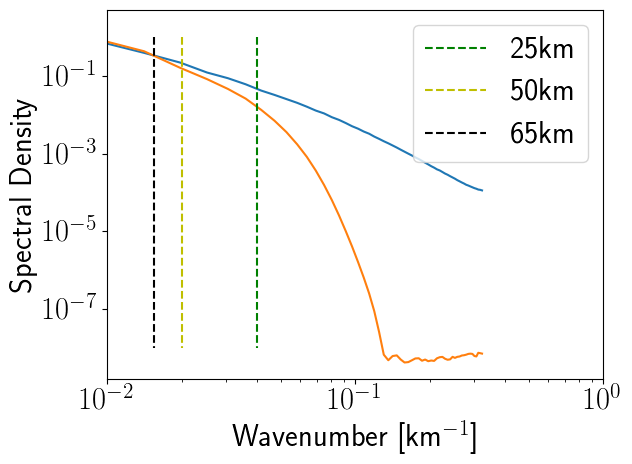

In [84]:
sst_f=varfw.SST.compute()
sst_t=vartw.SST.compute()
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'


T_SMTH=xrft.isotropic_power_spectrum(sst_t[:,:,30:-100].drop(['nav_lat', 'nav_lon']),
                                     dim=['y','x'],nfactor=nf,truncate='True',scaling=scl,detrend='linear',window=wdws,window_correction=wdw_cor)

T_FULL=xrft.isotropic_power_spectrum(sst_f[:,:,30:-100].drop(['nav_lat', 'nav_lon']),
                                     dim=['y','x'],nfactor=nf,truncate='True',scaling=scl,detrend='linear',window=wdws,window_correction=wdw_cor)

plt.figure()
plt.plot(T_FULL.freq_r/1.5,T_FULL.mean(axis=0))
plt.plot(T_SMTH.freq_r/1.5,T_SMTH.mean(axis=0))
plt.plot([1/25,1/25],[1,1e-8],'g--',label='25km')
plt.plot([1/50,1/50],[1,1e-8],'y--',label='50km')
plt.plot([1/65,1/65],[1,1e-8],'k--',label='65km')
plt.ylabel('Spectral Density')
plt.xlabel('Wavenumber [km$^{-1}$]')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1/1)


In [81]:
gc.collect()

54518

# Loading data

In [9]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [52]:
%%time
chunks_new={'time_counter':40}

tf=varf.temp#.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:,1:-1,1:-1]

tt=vart.temp#.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,100:-100,100:-200].compute();
tt=tt[:,1:-1,1:-1]

shf=varf.shflx#.groupby("time_counter.dayofyear").mean()
shf=shf.chunk(chunks=chunks_new);
shf=shf[:,100:-100,100:-200].compute();
shf=shf[:,1:-1,1:-1]

sht=vart.shflx#.groupby("time_counter.dayofyear").mean()
sht=sht.chunk(chunks=chunks_new);
sht=sht[:,100:-100,100:-200].compute();
sht=sht[:,1:-1,1:-1]


sf=varf.salt#.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,100:-100,100:-200].compute();
sf=sf[:,1:-1,1:-1]

st=vart.salt#.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,100:-100,100:-200].compute();
st=st[:,1:-1,1:-1]


CPU times: user 22.1 s, sys: 14.5 s, total: 36.6 s
Wall time: 10.8 s


# Computing $Bo_t$ and $b_T$

In [27]:
# N2r=(5.2*10**-3)**2
#use new computation from CROCO 3d
N2r=(3.9e-3)**2

In [54]:
cp=gsw.cp_t_exact(sf,tf,p=0).mean()
rho=1024
g=9.8

In [55]:
ct_f=gsw.CT_from_t(sf,tf,p=0)
alpha_f=gsw.alpha(sf,ct_f,p=0)
# lv_f=gsw.latentheat_evap_CT(sf,ct_f)


ct_t=gsw.CT_from_t(st,tt,p=0)
alpha_t=gsw.alpha(st,ct_t,p=0)
# lv_t=gsw.latentheat_evap_CT(st,ct_t)

In [56]:
Bot_f=-(alpha_f*g*shf)/(rho*cp)
Bot_t=-(alpha_t*g*sht)/(rho*cp)

bt_f=alpha_f*g*(tf-tf.mean(axis=1).mean(axis=1))#spatial reference
bt_t=alpha_t*g*(tt-tt.mean(axis=1).mean(axis=1))#spatial reference

# bt_f=alpha_f.mean()*g*(tf-tf.mean())#time and spatial reference
# bt_t=alpha_t.mean()*g*(tt-tt.mean())#time and spatial reference


# Computing $Bo_s$ and $b_S$

##### Loading data from WRF

In [44]:
varfw.coords['6htime']=varfw.time_counter.dt.floor('6H')
vartw.coords['6htime']=vartw.time_counter.dt.floor('6H')

In [47]:
%%time
# chunks_new={'time_counter':40}
lhtf=regrid(varfw.LH.groupby('6htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
lhtt=regrid(vartw.LH.groupby('6htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
Pf=regrid(varfw.RAIN.groupby('6htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
Pt=regrid(vartw.RAIN.groupby('6htime').mean(),
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_390x300_1520x1000.nc 
 You can set reuse_weights=True to save computing time.
CPU times: user 1min 41s, sys: 4.12 s, total: 1min 45s
Wall time: 1min 53s


In [48]:
# L=gsw.latentheat_evap_CT(sf,ct_f).mean().data #J   #/1000 #kJ
L=2257*1000 # Js/Kg

In [58]:
Evap_f=lhtf.data/(L*rho)# m/s   #*86400
Evap_t=lhtt.data/(L*rho)# m/s   #*86400 #mm/day

beta_f=gsw.beta(sf,ct_f,p=0)
beta_t=gsw.beta(st,ct_t,p=0)

In [50]:
# EP_f=Evap_f.mean(axis=1).mean(axis=1)-(Pf.mean(axis=1).mean(axis=1)/(86400*1000));
EP_f=Evap_f-(Pf.data/(86400*1000));
# EP_f=EP_f.assign_coords(DOY=('time_counter',sf.dayofyear.data))
# EP_f=EP_f.drop(['time_counter','time_centered'])
# EP_f=EP_f.rename({'time_counter':'dayofyear'})



# EP_t=Evap_t.mean(axis=1).mean(axis=1)-(Pt.mean(axis=1).mean(axis=1)/(86400*1000));
EP_t=Evap_t-(Pt.data/(86400*1000));
# EP_t=EP_t.assign_coords(DOY=('time_counter',st.dayofyear.data))
# EP_t=EP_t.drop(['time_counter','time_centered'])
# EP_t=EP_t.rename({'time_counter':'dayofyear'})

In [59]:
Bos_f=(g*beta_f)*(sf)*(EP_f)
Bos_t=(g*beta_t)*(st)*(EP_t)

bs_f=-g*beta_f*(sf-sf.mean(axis=1).mean(axis=1))
bs_t=-g*beta_t*(st-st.mean(axis=1).mean(axis=1))

# bs_f=-g*beta_f*(sf[:-1,:,:]-sf.mean())
# bs_t=-g*beta_t*(st[:-1,:,:]-st.mean())

In [60]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [65]:
%%time
with ProgressBar():
    btBt_f=xrft.isotropic_cross_spectrum(bt_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    btBt_t=xrft.isotropic_cross_spectrum(bt_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 50min 39s, sys: 2h 21min 38s, total: 3h 12min 18s
Wall time: 5min 51s


In [66]:
%%time
with ProgressBar():
    bsBs_f=xrft.isotropic_cross_spectrum(bs_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    bsBs_t=xrft.isotropic_cross_spectrum(bs_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

[########################################] | 100% Completed |  1min 46.4s
[########################################] | 100% Completed |  1min 32.3s
CPU times: user 1h 8min 52s, sys: 3h 27min 28s, total: 4h 36min 20s
Wall time: 6min 28s


In [67]:
%%time
with ProgressBar():
    btBs_f=xrft.isotropic_cross_spectrum(bt_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    btBs_t=xrft.isotropic_cross_spectrum(bt_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bos_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

[########################################] | 100% Completed | 32.5s
[########################################] | 100% Completed | 32.2s
CPU times: user 57min 43s, sys: 2h 38min 14s, total: 3h 35min 58s
Wall time: 4min 16s


In [68]:
%%time
with ProgressBar():
    bsBt_f=xrft.isotropic_cross_spectrum(bs_f.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_f.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real
    bsBt_t=xrft.isotropic_cross_spectrum(bs_t.drop(['nav_lat_rho','nav_lon_rho']),
                                         Bot_t.drop(['nav_lat_rho','nav_lon_rho']),dim=['y_rho','x_rho'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).real

CPU times: user 49min 54s, sys: 2h 25min 39s, total: 3h 15min 33s
Wall time: 6min 57s


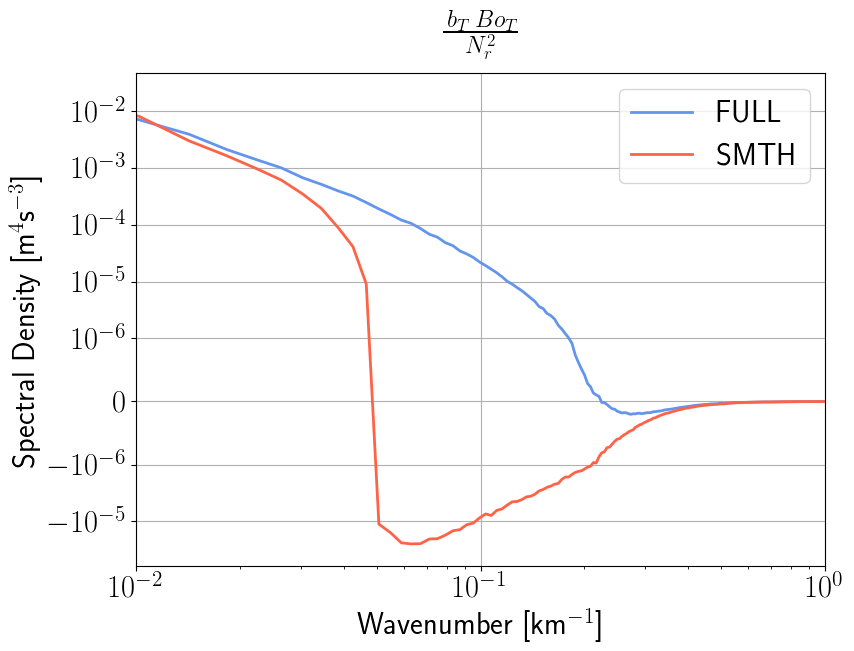

In [26]:
plt.figure(figsize=(9,7))


plt.plot(btBt_f.freq_r/dxx,((1/N2r)*btBt_f.mean(axis=0))/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(btBt_t.freq_r/dxx,((1/N2r)*btBt_t.mean(axis=0))/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()
plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{\,b_T \,Bo_T}{N^2_r}$',fontsize=25,y=1.05)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')

plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')

plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bTBoT_spectral.png')



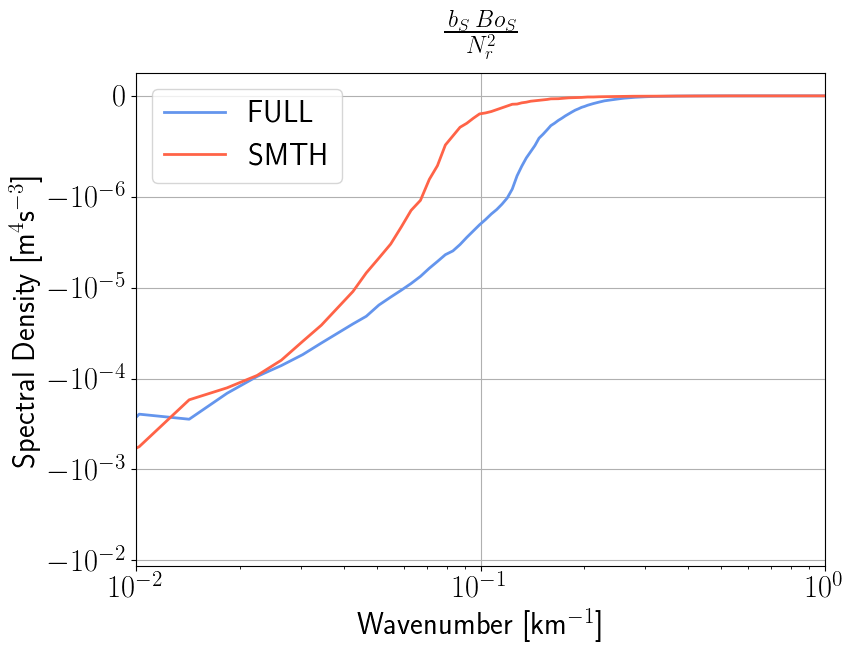

In [27]:
plt.figure(figsize=(9,7))


plt.plot(bsBs_f.freq_r/dxx,((1/N2r)*bsBs_f.mean(axis=0))/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(bsBs_t.freq_r/dxx,((1/N2r)*bsBs_t.mean(axis=0))/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{ \,b_S \,Bo_S}{N^2_r}$',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')

plt.xlim(1/100,1)
# plt.ylim(1e-8,1e-1)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bSBoS_spectral.png')



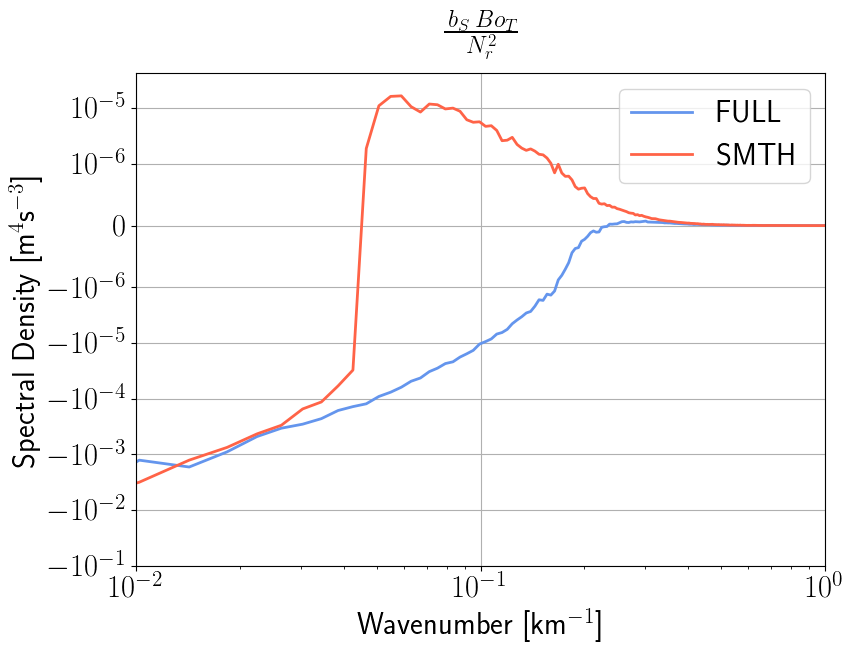

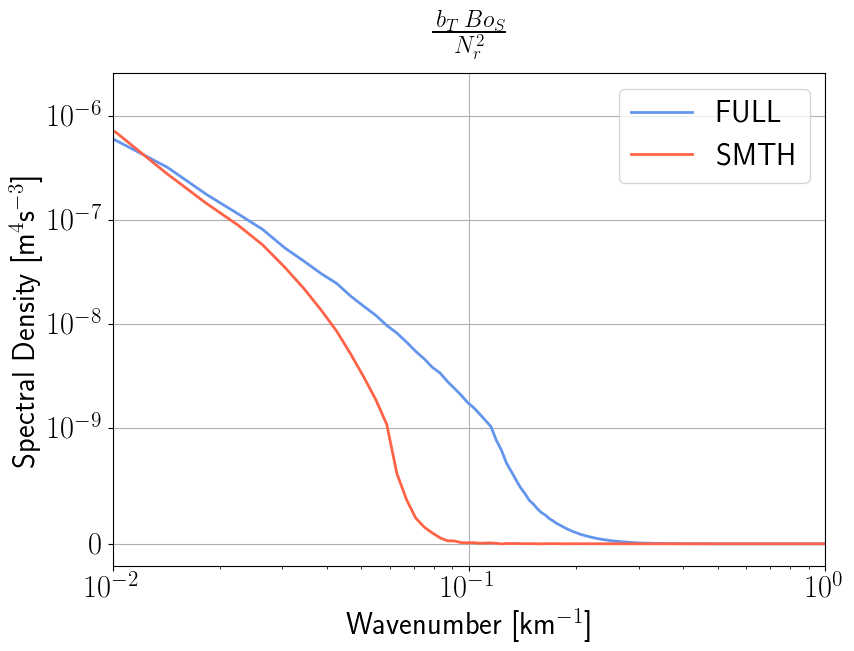

In [28]:
plt.figure(figsize=(9,7))


plt.plot(bsBt_f.freq_r/dxx,((1/N2r)*bsBt_f.mean(axis=0))/dxx*1e3,label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(bsBt_t.freq_r/dxx,((1/N2r)*bsBt_t.mean(axis=0))/dxx*1e3,label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-6)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{ \,b_S \,Bo_T}{N^2_r}$',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bSBoT_spectral.png')





plt.figure(figsize=(9,7))


plt.plot(btBs_f.freq_r/dxx,(1/N2r)*btBs_f.mean(axis=0),label='FULL',linewidth=2,color='cornflowerblue')
plt.plot(btBs_t.freq_r/dxx,(1/N2r)*btBs_t.mean(axis=0),label='SMTH',linewidth=2,color='tomato')

# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.yscale('symlog',linthresh=1e-9)
# plt.yscale('log')
plt.xscale('log')



plt.title(r'$\frac{ \,b_T \,Bo_S}{N^2_r}$',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bTBoS_spectral.png')




In [ ]:
plt.figure(figsize=(9,7))


plt.plot(btBt_f.freq_r/dxx,((1/N2r)*btBt_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_T \,Bo_T}{N^2_r}$',linewidth=2,color='red')
plt.plot(btBt_t.freq_r/dxx,((1/N2r)*btBt_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='red')


plt.plot(bsBs_f.freq_r/dxx,((1/N2r)*bsBs_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_S \,Bo_S}{N^2_r}$',linewidth=2,color='navy')
plt.plot(bsBs_t.freq_r/dxx,((1/N2r)*bsBs_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='navy')


plt.plot(bsBt_f.freq_r/dxx,((1/N2r)*bsBt_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_s \,Bo_T}{N^2_r}$',linewidth=2,color='turquoise')
plt.plot(bsBt_t.freq_r/dxx,((1/N2r)*bsBt_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='turquoise')



plt.plot(btBs_f.freq_r/dxx,((1/N2r)*btBs_f.mean(axis=0))/dxx*1e3,label=r'$\frac{ \,b_T \,Bo_S}{N^2_r}$',linewidth=2,color='tomato')
plt.plot(btBs_t.freq_r/dxx,((1/N2r)*btBs_t.mean(axis=0))/dxx*1e3,'--',linewidth=2,color='tomato')


# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 20})

plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')
plt.xscale('log')



# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
# plt.ylim(0,1e-11)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_all_spectral_v.png')





## Sum of all components

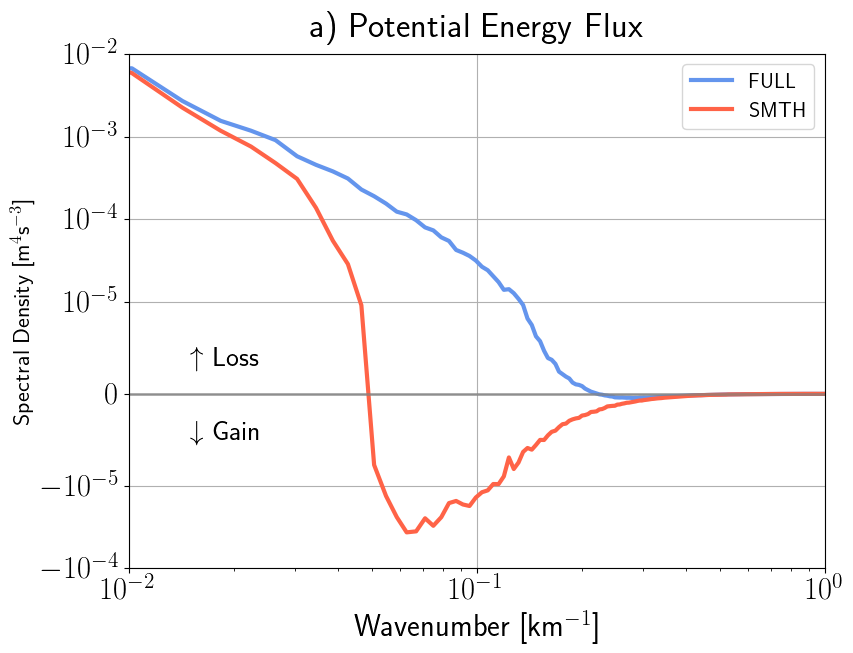

In [69]:
# plt.figure(figsize=(9,4))
plt.figure(figsize=(9,7))



plt.plot(btBt_f.freq_r/dxx,
         ((1/N2r)*(btBt_f.mean(axis=0)+bsBs_f.mean(axis=0)+bsBt_f.mean(axis=0)+btBs_f.mean(axis=0)))/dxx*1e3,
                                      label='FULL',linewidth=3,color='cornflowerblue')
plt.plot(btBt_t.freq_r/dxx,
         ((1/N2r)*(btBt_t.mean(axis=0)+bsBs_t.mean(axis=0)+bsBt_t.mean(axis=0)+btBs_t.mean(axis=0)))/dxx*1e3,
                                     label='SMTH',linewidth=3,color='tomato')

plt.plot(btBt_t.freq_r/dxx,np.zeros(btBt_t[0].shape),linewidth=2,color='grey',alpha=0.7)





# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend(prop={'size': 15})

plt.yscale('symlog',linthresh=1e-5)
# plt.yscale('log')
plt.xscale('log')
# plt.title(r'$\frac{ \,b \,Bo}{N^2_r}$',fontsize=20)

# plt.title(r'$F_{PE}$',fontsize=25,y=1.05)
plt.title(r'a) Potential Energy Flux',fontsize=25,y=1.02)


# plt.text(0.5,5e-3,r'F$_{PE}$',fontsize=25)
plt.text(1.5e-2,0.3e-5,r'$\uparrow$ Loss ',fontsize=20)
plt.text(1.5e-2,-0.5e-5,r'$\downarrow$ Gain ',fontsize=20)




# plt.title(r'$b_S*Bo_T$',fontweight='bold',fontsize=15)
plt.ylabel(r'Spectral Density [m$^{4}$s$^{-3}$]',fontweight='bold',fontsize=17)
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


plt.xlim(1/100,1)
plt.ylim(-1e-4,1e-2)
plt.grid()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_sum_spectral_v2poster_test2.png')


# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/bBo_sum_spectral.png')






In [47]:
FPE_f=(1/N2r)*(btBt_f.mean(axis=0)+bsBs_f.mean(axis=0)+bsBt_f.mean(axis=0)+btBs_f.mean(axis=0))
FPE_t=(1/N2r)*(btBt_t.mean(axis=0)+bsBs_t.mean(axis=0)+bsBt_t.mean(axis=0)+btBs_t.mean(axis=0))

In [ ]:
'Ogive graph'

KAf=ogive(btBt_f.freq_r/dxx*1e3,
          FPE_f/dxx*1e3) #in metersss

Kx=btBt_f.freq_r/dxx #in Kilometers

KAt=ogive(btBt_t.freq_r/dxx*1e3,
          FPE_t/dxx*1e3)#in metersss

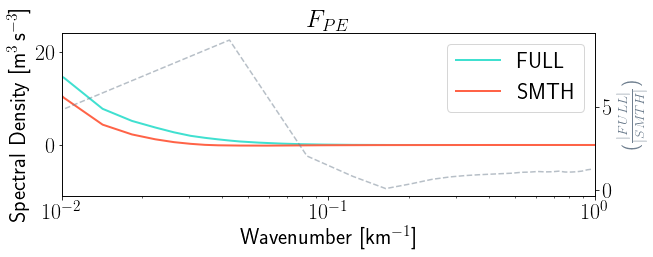

In [65]:

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((Kx),KAf,label='FULL',linewidth=2,color='cornflowerblue')
ax.plot((Kx),KAt,label='SMTH',linewidth=2,color='tomato')
# ax.set_title('KE (Ogive)',fontsize=15,fontweight='bold')


ax.set_xscale('log')


ax.set_xlabel(r'Wavenumber [km$^{-1}$]',fontweight='bold')
ax.set_ylabel(r'Spectral Density [m$^3\,$s$^{-3}$]',fontweight='bold')
ax.set_title(r'$F_{PE}$',fontsize=25)
ax.set_xlim(1e-2,1)
# ax.set_ylim(-0.1,2e6)



ax.legend()
dec=10
ax2=ax.twinx()
# ax2.plot((Kx),((KAf)/(KAt)-1)*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.plot((Kx[::dec]),(np.abs(KAf[::dec])/np.abs(KAt[::dec])),alpha=0.5,linestyle='dashed',color='slategrey')
# ax2.set_ylim(-1,1.5)



ax2.set_ylabel(r'($\frac{|FULL|}{|SMTH|}$)',fontweight='bold',fontsize=20,color='slategrey')
ax2.set_xscale('log')
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/bBo/ogive_bBo_sum_spectral.png')

